In [1]:
import os
import re

from typing import List, Dict, Any, Optional
from langchain.tools import tool
from langchain_openai import ChatOpenAI
from langchain_community.document_loaders import TextLoader
from langchain_community.vectorstores import FAISS
from langchain_openai import OpenAIEmbeddings
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_core.documents import Document
from langchain_core.messages import HumanMessage, AIMessage
from langchain_core.prompts import ChatPromptTemplate
from langgraph.graph import StateGraph, END
from langgraph.prebuilt import create_react_agent
from dotenv import load_dotenv
import warnings
warnings.filterwarnings('ignore')


c:\Users\winds\AppData\Local\pypoetry\Cache\virtualenvs\mylangchain-app-SBe-Yh6W-py3.13\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# 환경변수 설정
load_dotenv()
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")

# LLM 초기화
llm = ChatOpenAI(
    model="gpt-3.5-turbo",
    temperature=0.1
)


In [3]:

# 기존 벡터 DB 로드 (4-1.ipynb에서 생성된 것 사용)
def load_vector_db():
    
    try:
        embeddings = OpenAIEmbeddings()
        vectorstore = FAISS.load_local("../db/cafe_db", embeddings, allow_dangerous_deserialization=True)
        print("벡터 DB 정상 로드")
        return vectorstore
    except Exception as e:
        print(f"벡터 DB 로드 실패: {e}")
        
        return None

# 벡터 DB 로드
menu_db = load_vector_db()


벡터 DB 정상 로드


In [4]:
# 고급 정보 추출 함수
def extract_menu_info(doc: Document) -> dict:
    """Vector DB 문서에서 구조화된 메뉴 정보 추출"""
    content = doc.page_content
    
    # 정규표현식으로 가격, 설명 등 추출
    price_match = re.search(r'₩([\d,]+)', content)
    description_match = re.search(r'설명:\s*(.+?)(?:\n|$)', content, re.DOTALL)
    ingredients_match = re.search(r'주요 원료:\s*(.+?)(?:\n|$)', content, re.DOTALL)
    
    # 메뉴 이름 추출 (첫 번째 줄에서 숫자 제거)
    menu_name_match = re.search(r'^\d+\.\s*(.+?)(?:\n|$)', content, re.MULTILINE)
    
    return {
        "name": menu_name_match.group(1).strip() if menu_name_match else "메뉴명 없음",
        "price": price_match.group(0) if price_match else "가격 정보 없음",
        "description": description_match.group(1).strip() if description_match else "설명 없음",
        "ingredients": ingredients_match.group(1).strip() if ingredients_match else "재료 정보 없음"
    }

# 1. 메뉴 검색 도구
@tool
def search_menu(query: str) -> str:
    """카페 메뉴를 검색합니다. 사용자의 질문을 그대로 검색어로 사용하여 관련 메뉴 정보를 찾습니다."""
    if not menu_db:
        return "메뉴 데이터베이스를 사용할 수 없습니다."
    
    try:
        # 사용자 문의를 그대로 검색어로 사용 (의미론적 검색)
        docs = menu_db.similarity_search(query, k=4)
        
        if not docs:
            return "해당하는 메뉴를 찾을 수 없습니다."
        
        results = []
        for i, doc in enumerate(docs, 1):
            menu_info = extract_menu_info(doc)
            result = f"""
{i}. {menu_info['name']}
   가격: {menu_info['price']}
   재료: {menu_info['ingredients']}
   설명: {menu_info['description'][:100]}...
"""
            results.append(result)
        
        return "\n".join(results)
    except Exception as e:
        return f"메뉴 검색 중 오류가 발생했습니다: {str(e)}"

# 2. 가격 정보 검색 도구
@tool
def search_prices(query: str) -> str:
    """메뉴의 가격 정보를 검색합니다."""
    if not menu_db:
        return "메뉴 데이터베이스를 사용할 수 없습니다."
    
    try:
        # 가격 관련 검색
        docs = menu_db.similarity_search("가격", k=5)
        
        if not docs:
            return "가격 정보를 찾을 수 없습니다."
        
        results = []
        for doc in docs:
            menu_info = extract_menu_info(doc)
            if menu_info['price'] != "가격 정보 없음":
                results.append(f"{menu_info['name']}: {menu_info['price']}")
        
        return "\n".join(results) if results else "가격 정보를 찾을 수 없습니다."
    except Exception as e:
        return f"가격 검색 중 오류가 발생했습니다: {str(e)}"

# 3. 메뉴 추천 도구
@tool
def recommend_menu(query: str) -> str:
    """사용자의 요청에 따라 메뉴를 추천합니다."""
    if not menu_db:
        return "메뉴 데이터베이스를 사용할 수 없습니다."
    
    try:
        # 사용자 메시지로 먼저 검색
        docs = menu_db.similarity_search(query, k=3)
        
        # 결과가 없으면 기본 추천 키워드로 검색
        if not docs:
            docs = menu_db.similarity_search("인기 메뉴", k=3)
        
        if not docs:
            return "추천할 메뉴를 찾을 수 없습니다."
        
        results = []
        for i, doc in enumerate(docs, 1):
            menu_info = extract_menu_info(doc)
            result = f"""
{i}. {menu_info['name']} - {menu_info['price']}
   {menu_info['description'][:80]}...
"""
            results.append(result)
        
        return "\n".join(results)
    except Exception as e:
        return f"메뉴 추천 중 오류가 발생했습니다: {str(e)}"

# 도구 리스트
tools = [search_menu, search_prices, recommend_menu]

print("도구 정의 완료:")
for tool in tools:
    print(f"- {tool.name}: {tool.description}")


도구 정의 완료:
- search_menu: 카페 메뉴를 검색합니다. 사용자의 질문을 그대로 검색어로 사용하여 관련 메뉴 정보를 찾습니다.
- search_prices: 메뉴의 가격 정보를 검색합니다.
- recommend_menu: 사용자의 요청에 따라 메뉴를 추천합니다.


In [5]:
# ReAct Agent 생성
agent = create_react_agent(
    model=llm,
    tools=tools,
    prompt=ChatPromptTemplate.from_messages([
        ("system", """당신은 카페 직원입니다. 고객의 문의에 대해 답변해주세요.

사용 가능한 도구들:
- search_menu: 메뉴 검색 (사용자 질문을 그대로 검색어로 사용)
- search_prices: 가격 정보 검색
- recommend_menu: 메뉴 추천

고객의 질문 유형에 따라 적절한 도구를 선택하여 사용하세요:
- 특정 메뉴에 대한 질문 → search_menu 사용
- 가격 관련 질문 → search_prices 사용  
- 추천 요청 → recommend_menu 사용

답변은 한국어로 작성하고, 구체적인 정보(가격, 재료, 설명)를 포함해주세요."""),
        ("placeholder", "{messages}")
    ])
)

print("ReAct Agent가 성공적으로 생성되었습니다.")
print(f"사용 가능한 도구: {[tool.name for tool in tools]}")


ReAct Agent가 성공적으로 생성되었습니다.
사용 가능한 도구: ['search_menu', 'search_prices', 'recommend_menu']


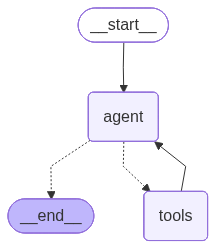

In [6]:
agent

In [8]:
def simulate_conversation():
    """대화 이력을 유지하는 시뮬레이션"""
    
    messages = []
    
    conversation = [
        "아메리카노 가격이 궁금해요.",
        "카페라떼도 얼마인가요?",
        "달콤한 커피 중에서 추천해주세요",
        "방금 추천한 메뉴들의 가격을 다시 알려주세요",
        "음료는 접시에 올려져서 서빙 되나요?",
        " 두번째로 질문한 메뉴의 특징이 뭐라고요?"
    ]
    
    for i, user_input in enumerate(conversation, 1):
        print(f"\n--- 대화 {i} ---")
        print(f"고객: {user_input}")
        
        
        messages.append(HumanMessage(content=user_input))
        
        try:
            # 에이전트 실행 (이전 대화 이력 포함)
            response = agent.invoke({"messages": messages})
    
            if response["messages"]:
                ai_message = response["messages"][-1]
            
                if isinstance(ai_message, AIMessage):
                    messages.append(ai_message)
                    print(f"직원: {ai_message.content}")
                else:
                    print(f"응답: {ai_message}")
            
        except Exception as e:
            print(f"오류 발생: {str(e)}")
    

simulate_conversation()



--- 대화 1 ---
고객: 아메리카노 가격이 궁금해요.
직원: 아메리카노의 가격은 ₩4,500입니다. 맛있게 즐기세요!

--- 대화 2 ---
고객: 카페라떼도 얼마인가요?
직원: 카페라떼의 가격은 ₩4,500입니다. 맛있게 즐기세요!

--- 대화 3 ---
고객: 달콤한 커피 중에서 추천해주세요
직원: 달콤한 커피로는 카라멜 마키아토를 추천드립니다. 카라멜 시럽과 휘핑크림이 올라간 스팀 밀크 위에 에스프레소를 부어 만들어진 달콤한 커피로, 카라멜의 진한 단맛과 커피의 깊은 맛이 조화를 이룹니다. 가격은 ₩6,500입니다. 맛있게 즐겨보세요!

--- 대화 4 ---
고객: 방금 추천한 메뉴들의 가격을 다시 알려주세요
직원: - 아메리카노: ₩4,500
- 카페라떼: ₩4,500
- 카라멜 마키아토: ₩6,500

위 가격으로 메뉴를 즐겨보세요!

--- 대화 5 ---
고객: 음료는 접시에 올려져서 서빙 되나요?
직원: 커피나 음료는 일반적으로 접시에 올려져서 서빙되지 않습니다. 대부분의 경우 음료는 컵이나 유리잔에 담겨 제공됩니다. 따뜻한 음료는 보통 컵에, 차나 콜드 음료는 유리잔에 담겨 제공됩니다. 맛있는 음료를 편안하게 즐기실 수 있도록 서빙해드립니다. 부담 없이 말씀해주세요.

--- 대화 6 ---
고객:  두번째로 질문한 메뉴의 특징이 뭐라고요?
직원: 카페라떼는 에스프레소와 스팀 밀크를 조합하여 만든 음료로, 부드럽고 크리미한 맛이 특징입니다. 에스프레소의 진한 풍미와 스팀 밀크의 부드러운 거품이 어우러져 부드럽고 깔끔한 맛을 즐길 수 있습니다. 카페인 함량이 적어 부드럽고 부드러운 커피를 선호하시는 분들에게 인기가 많은 메뉴입니다. 가격은 ₩4,500입니다. 맛있게 즐겨보세요!
